In this notebook, I'm going to build a image classification model to classify handwriten digits using Neural Network. We will use MNIST dataset containing 60000 grayscale image data. Each image is (28X28) means there are 784 pixels. This pixels have value as an integer between 0 and 255.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
(train_set, train_labels), (test_set, test_labels) = keras.datasets.mnist.load_data()
print(train_set.shape)
print(test_set.shape)

(60000, 28, 28)
(10000, 28, 28)


Visualize data

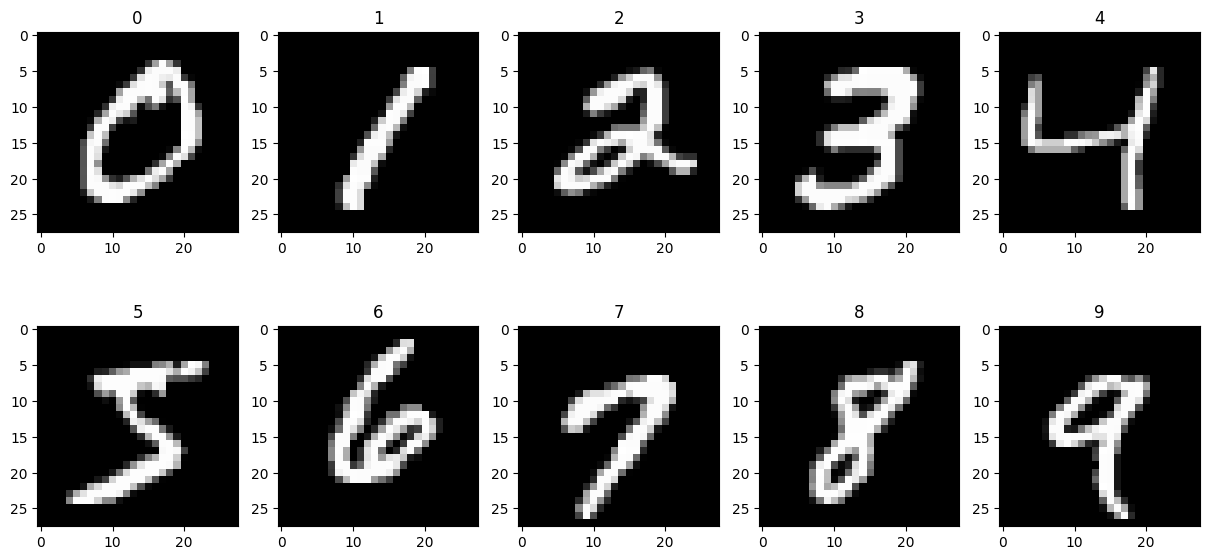

In [3]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.arange(0,10), start=1):
    ind = np.where(train_labels==c)[0][0]
    plt.subplot(2, 5, i)
    plt.title(c)
    plt.imshow(train_set[ind], cmap = 'gray')

<AxesSubplot:ylabel='count'>

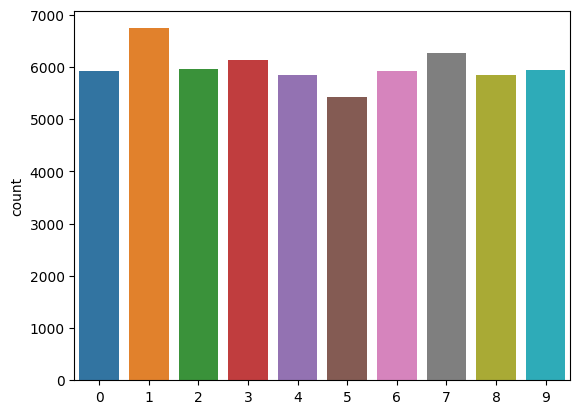

In [4]:
sns.countplot(x = train_labels)

PREPROCESS DATA

In [7]:
train_set_scaled = train_set / 255.0
test_set_scaled = test_set / 255.0

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_set_scaled, train_labels):
    X_train = train_set_scaled[train_index]
    x_valid = train_set_scaled[test_index]
    y_train = train_labels[train_index]
    y_valid = train_labels[test_index]

X_train.shape

(48000, 28, 28)

BUILDING A MODEL

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = (28, 28)))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 10)               

COMPILING MODEL

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

USING CALLBACKS

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

TRAINING AND VISUALISING MODEL

In [12]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7838 - accuracy: 0.7571 - val_loss: 0.4077 - val_accuracy: 0.8838
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4038 - accuracy: 0.8831 - val_loss: 0.3092 - val_accuracy: 0.9103
Epoch 3/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3299 - accuracy: 0.9057 - val_loss: 0.2640 - val_accuracy: 0.9229
Epoch 4/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2876 - accuracy: 0.9175 - val_loss: 0.2367 - val_accuracy: 0.9315
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2605 - accuracy: 0.9261 - val_loss: 0.2181 - val_accuracy: 0.9353
Epoch 6/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2395 - accuracy: 0.9328 - val_loss: 0.2028 - val_accuracy: 0.9404
Epoch 7/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2215 - accuracy: 0.9356 - val_loss: 0.1912 - val_a

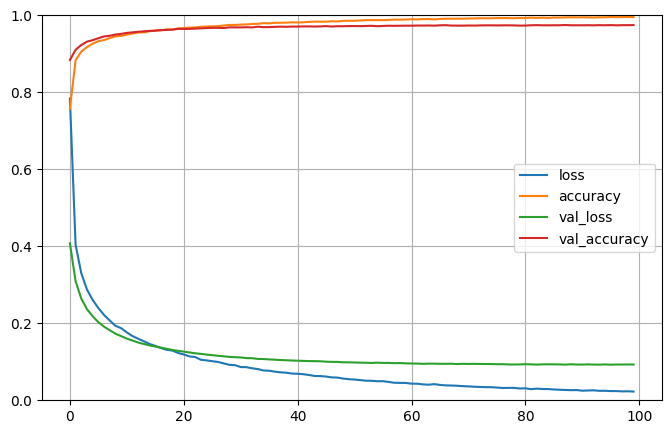

In [13]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [14]:
model = keras.models.load_model('my_model.h5')
model.evaluate(test_set_scaled, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0804 - accuracy: 0.9763


[0.0803690180182457, 0.9763000011444092]

FINE TUNING MODEL

In [2]:
def build_model(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = (28, 28)))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation = 'relu'))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(10, activation = 'softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])    
    return model

In [10]:
keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {'n_hidden' : [1, 2, 3], 'n_neurons' : np.arange(100, 500, 50), 'learning_rate': reciprocal(3e-4, 3e-2)}

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7848\1526989644.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [11]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs = 100, validation_data = (x_valid, y_valid), callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
1000/1000 [==============================] - 8s 6ms/step - loss: 0.2677 - accuracy: 0.9181 - val_loss: 0.1504 - val_accuracy: 0.9550
Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1324 - accuracy: 0.9601 - val_loss: 0.1298 - val_accuracy: 0.9623
Epoch 3/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0960 - accuracy: 0.9694 - val_loss: 0.1230 - val_accuracy: 0.9695
Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0758 - accuracy: 0.9759 - val_loss: 0.1091 - val_accuracy: 0.9713
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0621 - accuracy: 0.9797 - val_loss: 0.1195 - val_accuracy: 0.9720
Epoch 6/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0508 - accuracy: 0.9832 - val_loss: 0.1255 - val_accuracy: 0.9733
Epoch 7/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0439 - accuracy: 0.9853 - val_loss: 0.1161 - val_ac

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000019B20D5C970>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019B20D3FBB0>,
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': array([100, 150, 200, 250, 300, 350, 400, 450])})

In [13]:
print('best params:', rnd_search_cv.best_params_)
print('best_score:', rnd_search_cv.best_score_)

best params: {'learning_rate': 0.008609512688673004, 'n_hidden': 3, 'n_neurons': 300}
best_score: 0.976312498251597


In [14]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(test_set, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 689.9431 - accuracy: 0.7590


[689.9430541992188, 0.7590000033378601]

In [15]:
model.save('my_model.h5')

In [16]:
model_A = keras.models.load_model('my_model.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(512, activation = 'relu'))
model_B_on_A.add(keras.layers.Dense(10, activation = 'softmax'))

In [17]:
for layer in model_B_on_A.layers[:-2]:
    layer.trainable = False

optimizer = keras.optimizers.SGD()
model_B_on_A.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [18]:
model_B_on_A.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization_93 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_93 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_94 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_94 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization_95 (Bat  (None, 300)            

In [19]:
history = model_B_on_A.fit(X_train, y_train, epochs=5, validation_data = (x_valid, y_valid))

Epoch 1/5
1500/1500 [==============================] - 16s 10ms/step - loss: 0.0685 - accuracy: 0.9896 - val_loss: 0.0739 - val_accuracy: 0.9793
Epoch 2/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0133 - accuracy: 0.9980 - val_loss: 0.0710 - val_accuracy: 0.9802
Epoch 3/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0094 - accuracy: 0.9985 - val_loss: 0.0705 - val_accuracy: 0.9802
Epoch 4/5
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0075 - accuracy: 0.9988 - val_loss: 0.0709 - val_accuracy: 0.9807
Epoch 5/5
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0713 - val_accuracy: 0.9811


In [20]:
for layer in model_B_on_A.layers[:-2]:
    layer.trainable = True

checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model2.h5', save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
optimizer = keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

In [21]:
history = model_B_on_A.fit(X_train, y_train, epochs=100, validation_data = (x_valid, y_valid), callbacks = [checkpoint_cb, earlystop_cb])

Epoch 1/100
1500/1500 [==============================] - 20s 12ms/step - loss: 0.0239 - accuracy: 0.9942 - val_loss: 0.0718 - val_accuracy: 0.9806
Epoch 2/100
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0240 - accuracy: 0.9936 - val_loss: 0.0715 - val_accuracy: 0.9805
Epoch 3/100
1500/1500 [==============================] - 19s 13ms/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.0727 - val_accuracy: 0.9804
Epoch 4/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0207 - accuracy: 0.9948 - val_loss: 0.0713 - val_accuracy: 0.9809
Epoch 5/100
1500/1500 [==============================] - 19s 13ms/step - loss: 0.0205 - accuracy: 0.9947 - val_loss: 0.0708 - val_accuracy: 0.9807
Epoch 6/100
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0209 - accuracy: 0.9948 - val_loss: 0.0724 - val_accuracy: 0.9811
Epoch 7/100
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0200 - accuracy: 0.9947 - val_loss: 0

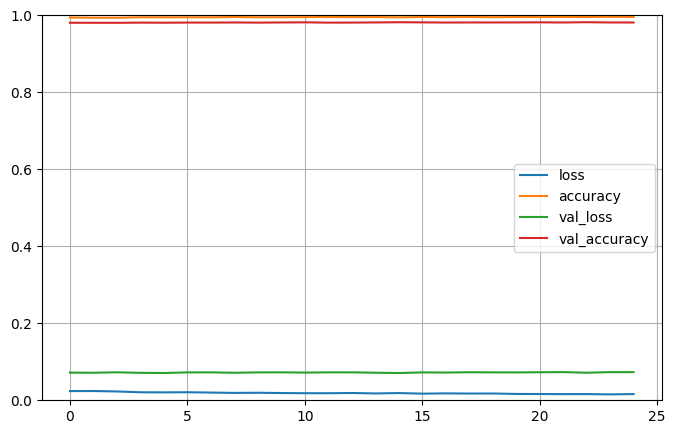

313/313 [==============================] - 2s 4ms/step - loss: 0.0698 - accuracy: 0.9816


[0.06977422535419464, 0.9815999865531921]

In [24]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
model_B_on_A.evaluate(test_set_scaled, test_labels)

In [23]:
model = keras.models.load_model('my_model2.h5')
preds = np.argmax(model.predict(test_set_scaled), axis = 1)

313/313 [==============================] - 2s 4ms/step


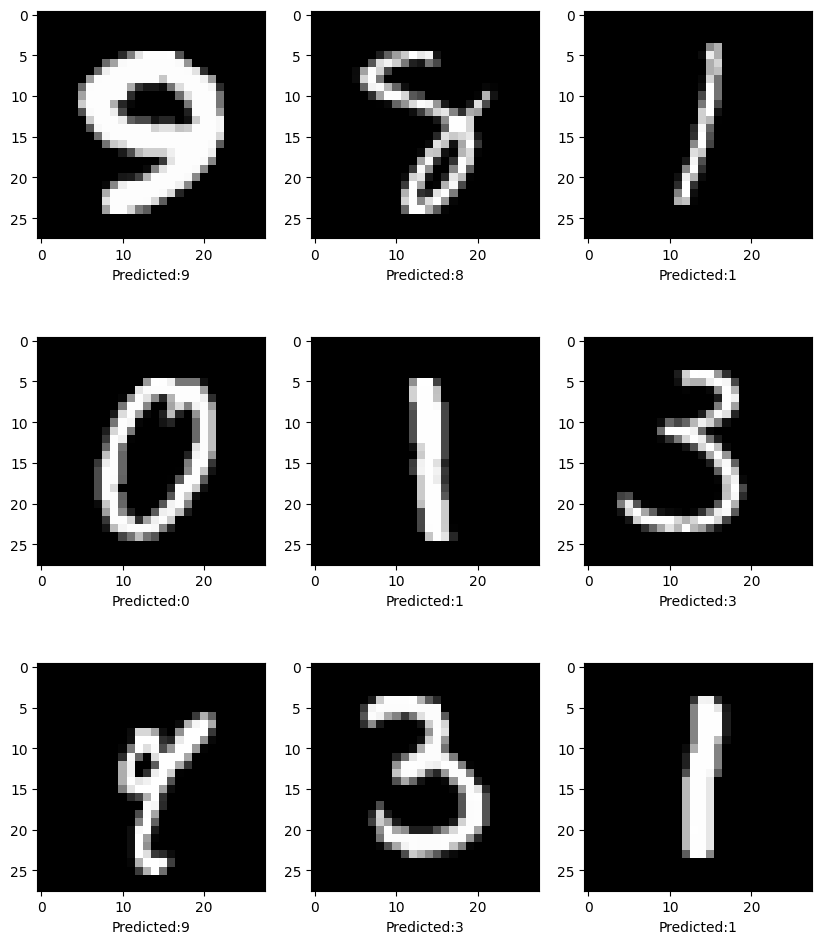

In [29]:
import random
plt.figure(figsize=(10,12))
for i, c in enumerate(random.sample(range(0, len(test_set)), 9), start = 1):
    plt.subplot(3, 3, i)
    t = test_set[c]
    plt.xlabel('Predicted:' + str(preds[c]))
    plt.imshow(t.reshape(28,28), cmap = 'gray')